# Baseline & Testing Models
---

This section will use gridsearch to narrow in on best hyperparameters of vectorizers and estimators. 8 models in total will be created and scored using different classification metrics. Count Vectorizer and Tfidf Vectorizer will be coupled with 4 different classification modelling techniques:
* Logistic Regression
* KNN
* Naive Bayes
* Random Forest

Will be doing preliminary model performance evaluation using accuracy (ie. ratio of correctly classified posts to total number of predictions) as our classification metric since we have balanced classes (50% of posts belong to r/lotr and the other 50% to r/harrypotter).

In [140]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# nltk imports
from nltk.corpus import stopwords


In [141]:
# Import raw data.
df = pd.read_csv('../data/raw_data.csv')

In [142]:
# Set up X and y for baseline accuracy.
# Using the 'title' column as our X, since contains most of the text data in the dataframe.
X = df['title']
y = df['subreddit']

In [143]:
y.value_counts(normalize = True)

lotr           0.5
harrypotter    0.5
Name: subreddit, dtype: float64

### Baseline Accuracy
Baseline accuracy is 0.5 or 50%. That is, the probability of sorting a post into the correct subreddit is 50% if sorted randomly.

### Train-test Split

In [144]:
# Split the data for train-test split to evaluat our models.
# Use the default split ratio and a random state of 77.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 77, stratify = y)

In [145]:
# Check that the train and test sets are properly stratified.
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

harrypotter    0.5
lotr           0.5
Name: subreddit, dtype: float64
harrypotter    0.5
lotr           0.5
Name: subreddit, dtype: float64


### I. Count Vectorizer and Logistic Regression
---

First model processes the text data using a count vectorizer and then fits a logistic regression model to make predictions.

In [168]:
# Set up pipeline of CV + LR with default params.

pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter = 10_000))
     ])
pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(max_iter=10000))])

In [169]:
# Check performance on train and test data.
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.9949333333333333
0.9912


In [170]:
# Set grid of hyperparameters to grid search through.
pipe_params = {
    'cv__max_features': [2000, 3000, 4000],
    'cv__stop_words': [None, 'english', stopwords.words('english')],
    'cv__min_df': [2, 4],
    'cv__max_df': [1.0, .8, .5],
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none']
}

In [171]:
# Perform grid search and fit the training data.
gs = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 n_jobs = -1)
gs.fit(X_train, y_train)

/Users/makenamaryannejones/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/makenamaryannejones/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/makenamaryannejones/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/makenamaryannejones/opt/anaconda3/lib/python3.9/site-packages/

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'cv__max_df': [1.0, 0.8, 0.5],
                         'cv__max_features': [2000, 3000, 4000],
                         'cv__min_df': [2, 4],
                         'cv__stop_words': [None, 'english',
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                  

In [172]:
# Print best cross-validated score (accuracy) and the best hyperparameters used.
print(gs.best_score_)
print(gs.best_params_)

0.9940000000000001
{'cv__max_df': 1.0, 'cv__max_features': 4000, 'cv__min_df': 2, 'cv__stop_words': None, 'lr__penalty': 'none'}


In [174]:
# Compare how the model performs on training and test set.
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9989333333333333
0.9992


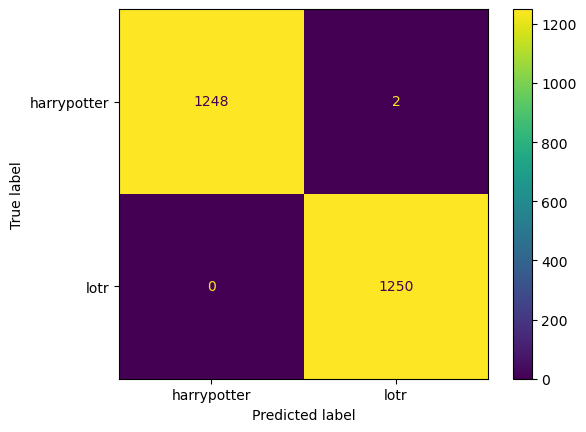

In [175]:
# Generate predictions on the test data.
pred = gs.predict(X_test)

# Create a confusion matrix to better visualize how the model performs.
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

Overall, model performs really well with an accuracy of 99.9% on both testing and training data. Only 2 posts were missclassified (false positives if we say belonging to r/harrypotter is our positive class as 2 posts that were from the r/harrypotter subreddit were classified as being from the r/lotr subreddit ).

In [246]:

misclassified = np.where(y_test != pred)

In [247]:
misclassified

(array([1291, 2035]),)

In [244]:
X_test[1291]

"What's the point of mandos's judgment if any elf can just build a boat and go to Aman themselves"

### II. TfidVectorizer and KNN
---

Second model processes the text data using a TF-IDF vectorizer and then fits a K-Nearest Neighbours algorithm to make predictions.

In [177]:
# TFIDF + KNN.

# Set up pipeline.
pipe_knn = Pipeline([
    ('tf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Set up grid of hyperparameters to gridsearch through.
pipe_params_knn = {
    'tf__stop_words': [None, 'english',],
    'tf__max_features': [2000, 3000, 4000],
    'tf__min_df': [2, 4],
    'tf__max_df': [1.0, 0.8, 0.5],
    'knn__n_neighbors': [3, 5, 11]
}

# Instantiated gridsearch.
gs_knn = GridSearchCV(pipe_knn,
                     param_grid = pipe_params_knn,
                     n_jobs = -1)

# Fit model on training data.
gs_knn.fit(X_train, y_train)

# Print best accuracy and best hyperparameters for TF-IDF Vectorizer and KNN classifier.
print(gs_knn.best_score_)
print(gs_knn.best_params_)

0.9795999999999999
{'knn__n_neighbors': 3, 'tf__max_df': 1.0, 'tf__max_features': 4000, 'tf__min_df': 2, 'tf__stop_words': 'english'}


In [178]:
# Print accuracy of training and testing data.
print(gs_knn.score(X_train, y_train))
print(gs_knn.score(X_test, y_test))

0.9973333333333333
0.994


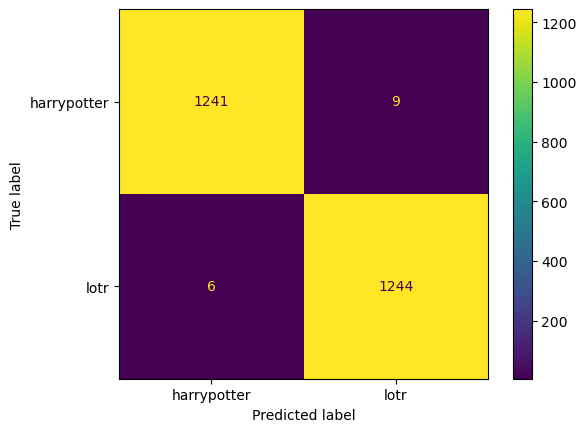

In [179]:
# Generate predictions on the test data.
knn_pred = gs_knn.predict(X_test)

# Create confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test, knn_pred).ravel()
ConfusionMatrixDisplay.from_estimator(gs_knn, X_test, y_test);

Overall, model performs really well with an accuracy of 99.7% on testing and 99.4% on training data. 15 posts are misclassified, however, compared to 2 in the previous model.

In [251]:
misclassified = np.where(y_test != gs_knn.predict(X_test))

In [252]:
misclassified

(array([ 140,  701,  863,  927, 1183, 1201, 1291, 1526, 1579, 1583, 1688,
        1869, 1983, 2003, 2180]),)

In [259]:
X_test[1983]

KeyError: 1983

### III. Logistic Regression and TFID Vectorizer
---

Third model processes the text data using a TF-IDF vectorizer and then fits a logistic regression model to make predictions.

In [180]:
# TF-IDF Vectorizer + Logistic Regression.
pipe3 = Pipeline([
    ('tf', TfidfVectorizer(stop_words= 'english',
    max_features = 4000, min_df= 2,max_df = 1.0,)),
    ('lr', LogisticRegression(penalty = 'none', max_iter = 10_000))
])
# Fit model on training data.
pipe3.fit(X_train, y_train,)

Pipeline(steps=[('tf',
                 TfidfVectorizer(max_features=4000, min_df=2,
                                 stop_words='english')),
                ('lr', LogisticRegression(max_iter=10000, penalty='none'))])

In [181]:
# Accuracies of training and testing sets.
print(pipe3.score(X_train, y_train))
print(pipe3.score(X_test, y_test))

0.9976
0.9972


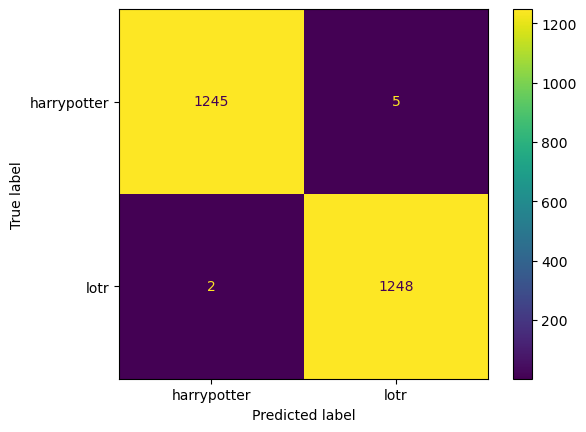

In [182]:
# Generate predictions on the test data.
pred3 = pipe3.predict(X_test)

# Create confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test, pred3).ravel()
ConfusionMatrixDisplay.from_estimator(pipe3, X_test, y_test);

Third model performs better than the second, but not quite as well as the first.

### IV. KNN and CountVectorizer
---

Fourth model transforms the text data using a Count vectorizer and then fits a k-Nearest Neighbours algorithm to make predictions.

In [184]:
# Count Vectorizer + KNN
# Instantiate model.
pipe4 = Pipeline([
    ('cv', CountVectorizer(max_df = 1.0, max_features = 4000, min_df= 2, stop_words= None)),
    ('knn', KNeighborsClassifier(n_neighbors = 3))
])
# Fit model on training data.
pipe4.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(max_features=4000, min_df=2)),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [185]:
# Print accuracy score for training and testing data.
print(pipe4.score(X_train, y_train))
print(pipe4.score(X_test, y_test))

0.998
0.988


In [186]:
# Generate predictions on the test data.
pred4 = pipe4.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, pred4).ravel()

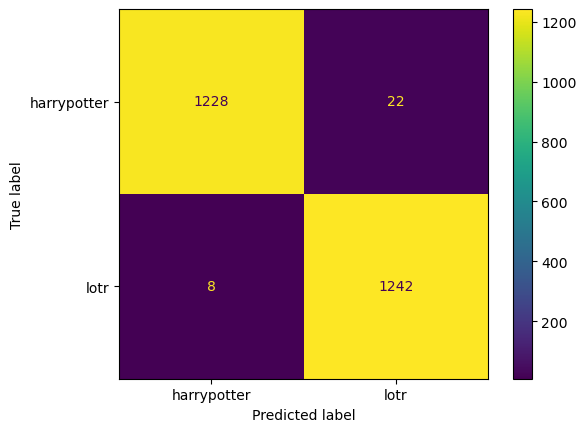

In [187]:
ConfusionMatrixDisplay.from_estimator(pipe4, X_test, y_test);

Fourth model does not outperform our first model.

### V. CountVectorizer and Naive Bayes
---

Fifth model transforms the text data using a Count vectorizer and then uses a Naive-Bayes classifier to make predictions.

In [189]:
# Count Vectorizer + Naive Bayes.
# Instantiate model.
pipe5 = Pipeline([
    ('cv', CountVectorizer(max_df = 1.0, max_features = 4000, min_df= 2, stop_words= None)),
    ('nb', MultinomialNB())
])

# Fit model on training data.
pipe5.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(max_features=4000, min_df=2)),
                ('nb', MultinomialNB())])

In [191]:
# Print accuracy score for training and testing data.
print(pipe5.score(X_train, y_train))
print(pipe5.score(X_test, y_test))

0.9644
0.9528


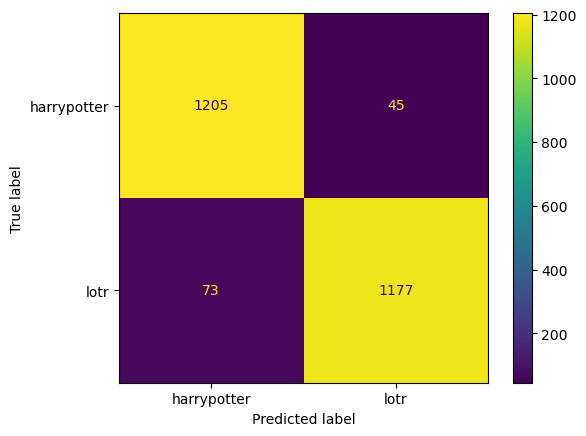

In [193]:
# Generate predictions on the test data.
pred5 = pipe5.predict(X_test)

# Create confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test, pred5).ravel()
ConfusionMatrixDisplay.from_estimator(pipe5, X_test, y_test);

Can see many more posts are missclassified.

### VI. TfidVectorizer and Naive Bayes

Sixth model transforms the text data using a Tfid vectorizer and then uses a Naive-Bayes classifier to make predictions.

In [197]:
# TF-IDF Vectorizer + Naive Bayes.
# Instantiate model.
pipe6 = Pipeline([
    ('tf', TfidfVectorizer(stop_words= 'english',
    max_features = 4000, min_df= 2,max_df = 1.0,)),
    ('nb',MultinomialNB())])

# Fit model on training data.
pipe6.fit(X_train, y_train)

# Print accuracies of training and testing sets.
print(pipe6.score(X_train, y_train))
print(pipe6.score(X_test, y_test))

0.9736
0.9672


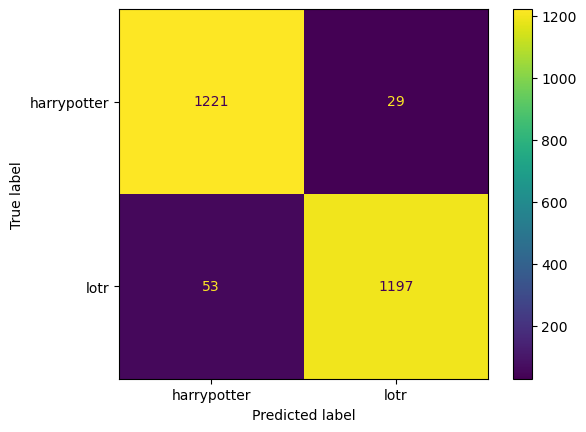

In [201]:
# Generate predictions on the test data.
pred6 = pipe6.predict(X_test)

# Create confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test, pred6).ravel()
ConfusionMatrixDisplay.from_estimator(pipe6, X_test, y_test);

Sixth model does not outperform best model.

### VII. Random Forest and Tfidf
---

In [203]:
# TF-IDF Vectorizer and Random Forest Classifier.
# Instantiate model.
pipe7 = Pipeline([
    ('tf', TfidfVectorizer(stop_words= 'english',
    max_features = 4000, min_df= 2,max_df = 1.0,)),
    ('rf', RandomForestClassifier(random_state = 77, n_estimators = 150,
    max_depth = 4000))
])
# Fit model on training data.
pipe7.fit(X_train, y_train)

Pipeline(steps=[('tf',
                 TfidfVectorizer(max_features=4000, min_df=2,
                                 stop_words='english')),
                ('rf',
                 RandomForestClassifier(max_depth=4000, n_estimators=150,
                                        random_state=77))])

In [204]:
# Print accuracies of training and testing sets.
print(pipe7.score(X_train, y_train))
print(pipe7.score(X_test, y_test))

0.9976
0.9952


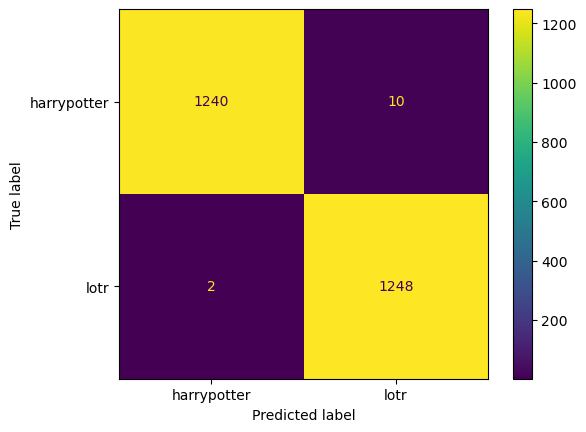

In [205]:
# Generate predictions on the test data.
pred7 = pipe7.predict(X_test)

# Create confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test, pred7).ravel()
ConfusionMatrixDisplay.from_estimator(pipe7, X_test, y_test);

Model performs well, but difference between training and testing accuracies suggest it is overfit (we got a better accuracy on our training set).

### VIII. Random Forest and CountVectorizer
---

In [206]:
pipe8 = Pipeline([
    ('cv', CountVectorizer(max_df = 1.0, max_features = 4000, min_df= 2, stop_words= None)),
    ('rf', RandomForestClassifier(random_state = 77, n_estimators = 150,
    max_depth = 4000))
])

# Fit model on training data.
pipe8.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(max_features=4000, min_df=2)),
                ('rf',
                 RandomForestClassifier(max_depth=4000, n_estimators=150,
                                        random_state=77))])

In [207]:
# Print accuracies of training and testing sets.
print(pipe8.score(X_train, y_train))
print(pipe8.score(X_test, y_test))

0.9989333333333333
0.9972


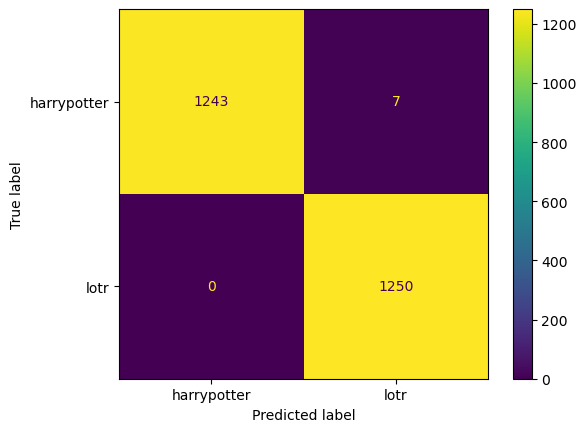

In [208]:
# Generate predictions on the test data.
pred8 = pipe8.predict(X_test)

# Create confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test, pred8).ravel()
ConfusionMatrixDisplay.from_estimator(pipe8, X_test, y_test);

### Comparing Models: ROC Curves 
---

/Users/makenamaryannejones/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/makenamaryannejones/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/makenamaryannejones/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is depr

Text(0.5, 0.98, 'ROC curve comparison')

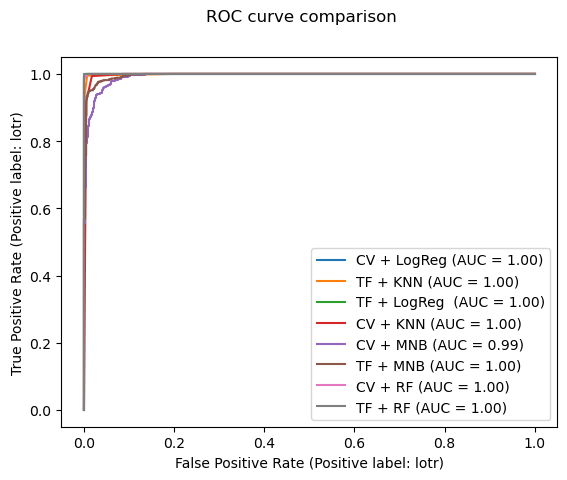

In [210]:
one_disp = plot_roc_curve(gs, X_test, y_test, name='CV + LogReg')
two_disp = plot_roc_curve(gs_knn, X_test, y_test, ax=one_disp.ax_,  name='TF + KNN')
three_disp = plot_roc_curve(pipe3, X_test, y_test, ax=one_disp.ax_,  name='TF + LogReg ')
four_disp = plot_roc_curve(pipe4, X_test, y_test, ax=one_disp.ax_,  name='CV + KNN')
five_disp = plot_roc_curve(pipe5, X_test, y_test, ax=one_disp.ax_,  name='CV + MNB')
six_disp = plot_roc_curve(pipe6, X_test, y_test, ax=one_disp.ax_,  name='TF + MNB')
seven_disp = plot_roc_curve(pipe7, X_test, y_test, ax=one_disp.ax_,  name='CV + RF')
eight_disp = plot_roc_curve(pipe8, X_test, y_test, ax=one_disp.ax_,  name='TF + RF')
one_disp.figure_.suptitle("ROC curve comparison")


### Conclusions & Findings
---
Our best performing model (count vectorizer and logistic regression) was extremely accurate and only missclassified two posts. We can conclude that the two fandoms are indeed very easy to distinguish based purely on the text data that users post. Looking forward, to answer the second part of my problem statement, would have to examine how we can distinguish two posts that do not contain direct references to the respective fandoms and lore. Applications of these models could involve sentiment analysis (ie. seeing how controversy around JK Rowling has affected sentiments of posts in this fandom space) and looking beyond to compare with other fandoms.